In [1]:
import numpy as np

In [2]:
class Kmeans:
    def __init__(self,k=8): # k is number of clusters
        self.num_cluster = k
        self.center = None # centers for different clusters
        self.cluster_label = np.zeros([k,]) # class labels for different clusters
        self.error_history = []

    def fit(self, X, y):
        # initialize the centers of clutsers as a set of pre-selected samples
        init_idx = [1, 200, 500, 1000, 1001, 1500, 2000, 2005]
        
        self.center = X[init_idx] #####

        num_iter = 0 # number of iterations for convergence

        # initialize the cluster assignment
        prev_cluster_assignment = np.zeros([len(X),]).astype('int')
        cluster_assignment = np.zeros([len(X),]).astype('int')
        is_converged = False

        # iteratively update the centers of clusters till convergence
        while not is_converged:

            # iterate through the samples and compute their cluster assignment (E step)
            for i in range(len(X)):
                # use euclidean distance to measure the distance between sample and cluster centers
                
                if len(X.shape) == 1: #####
                    t = [X - i for i in self.center] #####
                else: #####
                    t = np.sum((X[i] - self.center)**2, axis=1) #####

                # determine the cluster assignment by selecting the cluster whose center is closest to the sample
                
                cluster_assignment[i] = np.argmin(t) #####
                
            # update the centers based on cluster assignment (M step)
            
            for l in range(self.center.shape[0]): #####
                self.center[l] = np.mean(X[cluster_assignment == l, :], axis=0) #####

            # compute the reconstruction error for the current iteration
            cur_error = self.compute_error(X, cluster_assignment)
            self.error_history.append(cur_error)

            # reach convergence if the assignment does not change anymore
            is_converged = True if (cluster_assignment==prev_cluster_assignment).sum() == len(X) else False
            prev_cluster_assignment = np.copy(cluster_assignment)
            num_iter += 1

        # compute the class label of each cluster based on majority voting (remember to update the corresponding class attribute)        
        for ind_cluster in range(self.num_cluster):
            vote=np.zeros([self.num_cluster+2,])
            for ind_feature in range(len(X)):
                if cluster_assignment[ind_feature]==ind_cluster:
                    ind=int(y[ind_feature])
                    vote[ind]+=1
                    
            cluster_class=0
            for ind_vote in range(len(vote)):
                if vote[ind_vote]>vote[cluster_class]:
                    cluster_class=ind_vote
            self.cluster_label[ind_cluster]=cluster_class
        
        return num_iter, self.error_history

    def predict(self,X):
        # predicting the labels of test samples based on their clustering results
        prediction = np.ones([len(X),]) # placeholder

        # iterate through the test samples
        for i in range(len(X)):
            # find the cluster of each sample
            closest=0
            for ind_center in range(len(self.center)):
                distance=np.linalg.norm(X[i]-self.center[ind_center])
                if distance < np.linalg.norm(X[i] - self.center[closest]):
                    closest=ind_center
            prediction[i]=self.cluster_label[closest]
                    
            # use the class label of the selected cluster as the predicted class

        return prediction

    def compute_error(self,X,cluster_assignment):
        # compute the reconstruction error for given cluster assignment and centers
        error = 0 # placeholder
        for i, j in enumerate(X):  #####
            error += sum((j - self.center[cluster_assignment[i]]) ** 2)  #####
        return error

    def params(self):
        return self.center, self.cluster_label

In [3]:
import numpy as np

In [4]:
class PCA():
    def __init__(self,num_dim=None):
        self.num_dim = num_dim
        self.mean = np.zeros([1,784]) # means of training data
        self.W = None # projection matrix

    def fit(self,X):
        # normalize the data to make it centered at zero (also store the means as class attribute)
        self.mean=np.mean(X,axis=0)
        Xbar = X - self.mean
        # finding the projection matrix that maximize the variance (Hint: for eigen computation, use numpy.eigh instead of numpy.eig)
        S=np.cov(Xbar.T)
        eigenvalue,eigenvector=np.linalg.eigh(S)
        eigenvalue,eigenvector=eigenvalue[::-1],eigenvector[:,::-1]
        
        if self.num_dim is None:
            # select the reduced dimension that keep >90% of the variance
            denom=sum(eigenvalue)
            for i in range(len(eigenvalue)):
                num=sum(eigenvalue[0:i])
                Pov=num/denom
                if Pov > 0.9:
                    self.num_dim = i
                    break
            print(self.num_dim)
            # store the projected dimension

        # determine the projection matrix and store it as class attribute
        self.W = np.transpose(eigenvector[:,0:self.num_dim])

        # project the high-dimensional data to low-dimensional one
        X_pca = np.dot(Xbar,np.transpose(self.W))

        return X_pca, self.num_dim

    def predict(self,X):
        # normalize the test data based on training statistics
        Xbar = X - self.mean
        # project the test data
        X_pca = np.dot(Xbar,np.transpose(self.W))
        
        print(X_pca)
        
        return X_pca

    def params(self):
        return self.W, self.mean, self.num_dim

In [5]:
import numpy as np
from matplotlib import pyplot as plt
# from Mykmeans import Kmeans
# from MyPCA import PCA
import time

In [6]:
# read in data.
data=np.genfromtxt("Digits089.csv",delimiter=",")
Xtrain=data[data[:,0]!=5,2:]
ytrain=data[data[:,0]!=5,1]
Xtest=data[data[:,0]==5,2:]
ytest=data[data[:,0]==5,1]

In [7]:
# apply kmeans algorithms to raw data
clf = Kmeans(k=8)
start = time.time()
num_iter, error_history = clf.fit(Xtrain, ytrain)
time_raw = time.time() - start

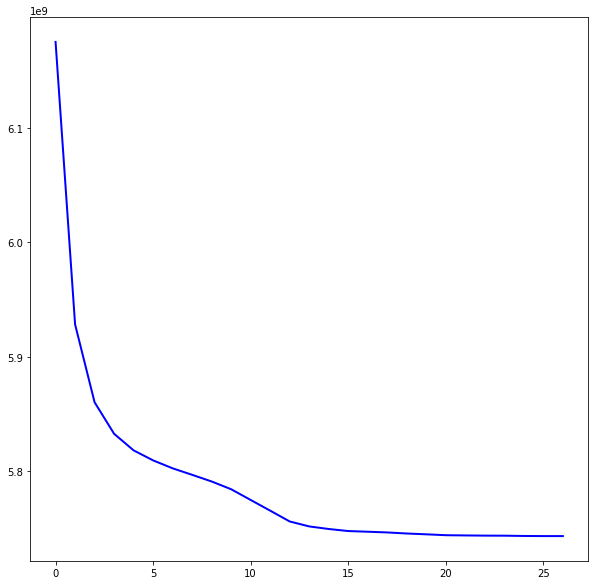

In [8]:
# plot the history of reconstruction error
fig = plt.figure()
plt.plot(np.arange(len(error_history)),error_history,'b-',linewidth=2)
fig.set_size_inches(10, 10)
fig.savefig('raw_data.png')
plt.show()

In [9]:
# using kmeans clustering for classification
predicted_label = clf.predict(Xtest)
acc_raw = np.count_nonzero(predicted_label==ytest)/len(Xtest)

In [10]:
# apply kmeans algorithms to low-dimensional data (PCA) that captures >90% of variance
pca = PCA()
Xtrain_pca, num_dim = pca.fit(Xtrain)
clf = Kmeans(k=8)
start = time.time()
num_iter_pca, error_history_pca = clf.fit(Xtrain_pca, ytrain)
time_pca = time.time() - start

73


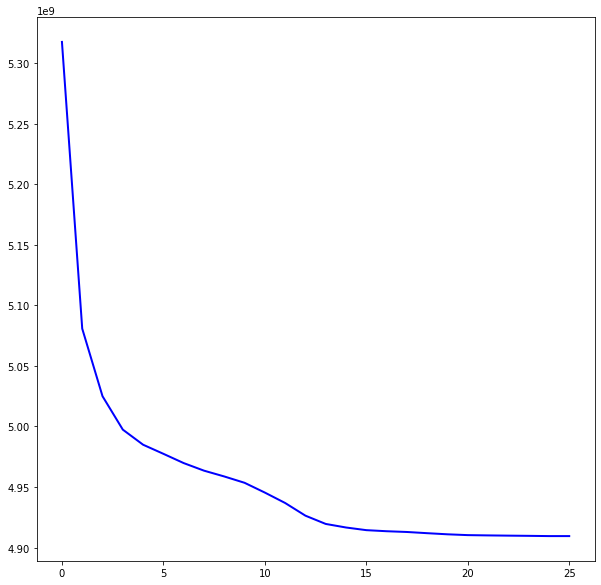

In [11]:
# plot the history of reconstruction error
fig1 = plt.figure()
plt.plot(np.arange(len(error_history_pca)),error_history_pca,'b-',linewidth=2)
fig1.set_size_inches(10, 10)
fig1.savefig('pca.png')
plt.show()

In [12]:
# using kmeans clustering for classification
Xtest_pca = pca.predict(Xtest)
predicted_label = clf.predict(Xtest_pca)
acc_pca = np.count_nonzero(predicted_label==ytest)/len(Xtest)

[[  660.0163196    641.80700261   292.73584689 ...   116.96391636
    176.35765368  -165.75305846]
 [  566.31781802   560.68839863   612.02479207 ...   -31.58541982
    -29.74087935    55.20623725]
 [  550.31754671   684.07282466   594.47160718 ...   100.10105331
     60.98245751   -70.60967545]
 ...
 [-1125.9234056     73.60157383  -717.60512378 ...   -59.89550152
     73.56736293   -21.1314794 ]
 [-1476.41675362   408.2695289   -506.45243697 ...    53.83022617
    -44.59088366   -55.34105062]
 [-1252.09600646    84.40296549  -545.72609127 ...   -76.40539078
   -141.45896216   -71.52934744]]


In [13]:
# apply kmeans algorithms to 1D feature obtained from PCA
pca = PCA(num_dim=1)
Xtrain_pca, _ = pca.fit(Xtrain)
clf = Kmeans(k=8)
start = time.time()
num_iter_pca_1, error_history_pca_1 = clf.fit(Xtrain_pca, ytrain)
time_pca_1 = time.time() - start

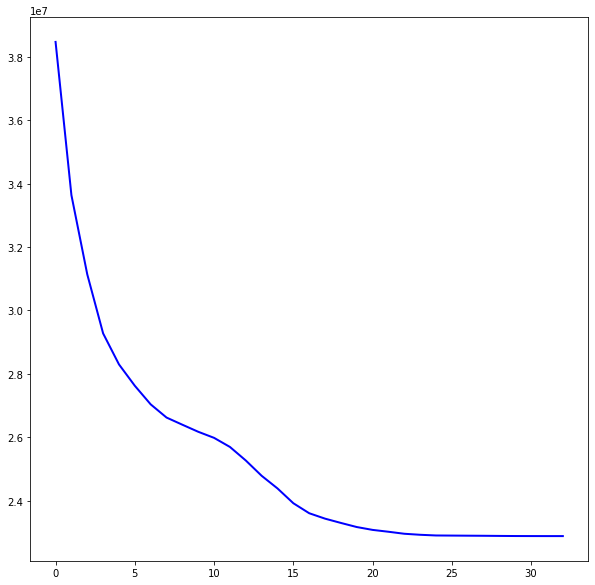

In [14]:
# plot the history of reconstruction error
fig2 = plt.figure()
plt.plot(np.arange(len(error_history_pca_1)),error_history_pca_1,'b-',linewidth=2)
fig2.set_size_inches(10, 10)
fig2.savefig('pca_1d.png')
plt.show()

In [15]:
# using kmeans clustering for classification
Xtest_pca = pca.predict(Xtest)
predicted_label = clf.predict(Xtest_pca)
acc_pca_1 = np.count_nonzero(predicted_label==ytest)/len(Xtest)

[[ 6.60016320e+02]
 [ 5.66317818e+02]
 [ 5.50317547e+02]
 [ 5.40785539e+02]
 [ 5.22867884e+02]
 [ 4.01424199e+02]
 [ 2.00576491e+02]
 [ 5.86276600e+02]
 [ 5.31853639e+02]
 [ 5.69474704e+02]
 [ 3.90385010e+02]
 [ 2.22542011e+02]
 [ 4.02171071e+02]
 [ 2.16735464e+01]
 [ 4.60460391e+02]
 [ 5.35898842e+02]
 [ 4.67708416e+02]
 [ 6.76925571e+02]
 [ 3.16776128e+02]
 [ 3.89455843e+02]
 [ 4.87249627e+02]
 [ 3.14202395e+02]
 [ 6.02275312e+02]
 [ 2.72327192e+02]
 [-4.52550485e+02]
 [ 3.91800174e+02]
 [ 1.45198676e+02]
 [ 3.37313955e+02]
 [ 6.92512123e+02]
 [ 4.20132304e+02]
 [ 4.47035869e+02]
 [ 4.79035887e+02]
 [ 1.03230140e+02]
 [ 2.54360791e+02]
 [ 3.62467086e+02]
 [ 6.28770674e+02]
 [ 6.81542658e+02]
 [ 5.03924786e+02]
 [ 4.17714041e+02]
 [ 5.68393220e+02]
 [ 6.71792283e+02]
 [ 5.70346921e+02]
 [ 6.98959930e+02]
 [ 3.06821268e+02]
 [ 3.78343577e+02]
 [ 4.12568953e+02]
 [ 7.93194845e+02]
 [ 5.24671257e+02]
 [ 5.21002446e+02]
 [ 1.43456399e+00]
 [ 5.95977272e+02]
 [ 1.30806966e+02]
 [ 1.1278232

In [16]:
# print the average information entropy and number of iterations for convergence
print('Using raw data converged in %d iteration (%.2f seconds)' %(num_iter,time_raw))
print('Classification accuracy: %.2f' %acc_raw)

Using raw data converged in 27 iteration (6.00 seconds)
Classification accuracy: 0.94


In [17]:
print('#################')
print('Project data into %d dimensions with PCA converged in %d iteration (%.2f seconds)'%(num_dim,num_iter_pca,time_pca))
print('Classification accuracy: %.2f' %acc_pca)


#################
Project data into 73 dimensions with PCA converged in 26 iteration (1.36 seconds)
Classification accuracy: 0.94


In [18]:
print('#################')
print('Project data into 1 dimension with PCA converged in %d iteration (%.2f seconds)'%(num_iter_pca_1,time_pca_1))
print('Classification accuracy: %.2f' %acc_pca_1)


#################
Project data into 1 dimension with PCA converged in 33 iteration (1.11 seconds)
Classification accuracy: 0.74
